# Churn Model for SyriaTell


### Created by Ethan Huffman

# Business Understanding

### At SyriaTel, we’ve been seeing more customers cancel their service, and bringing in new customers costs far more than keeping the ones we already have. To deal with this, we need a way to spot which customers are most likely to churn so our team can step in before they leave. Our goal is to build a model that predicts churn and prioritizes recall. With this model, we can take action in three important ways: generate a list of customers who may need immediate outreach, show how long wait times and repeated support calls contribute to churn, and identify high-value customers who may need targeted discounts to stay with us.

# Imports

In [32]:
# --- Core libraries ---
import os
import glob

import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Modeling & evaluation ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# --- Kaggle data download ---
import kagglehub

# Plot settings
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")

RANDOM_STATE = 42


### This cell loads all the libraries the project needs. It includes tools for data handling, visualizing charts, building machine learning models, and evaluating results. It also sets up KaggleHub for downloading the churn dataset.

# Data Understanding

In [33]:
# --- Download dataset from Kaggle using kagglehub ---

path = kagglehub.dataset_download("becksddf/churn-in-telecoms-dataset")
print("Dataset downloaded to:", path)

# Try to find a churn-related CSV automatically
csv_files = glob.glob(os.path.join(path, "*.csv"))
print("Found CSV files:", csv_files)

# Heuristic: prefer the file that has "churn" in its name; otherwise, use the first CSV
churn_csv = None
for f in csv_files:
    if "churn" in os.path.basename(f).lower():
        churn_csv = f
        break

if churn_csv is None:
    churn_csv = csv_files[0]  # fallback

print("Using CSV file:", churn_csv)

df = pd.read_csv(churn_csv)
df.head()


Dataset downloaded to: C:\Users\ehuff\.cache\kagglehub\datasets\becksddf\churn-in-telecoms-dataset\versions\1
Found CSV files: ['C:\\Users\\ehuff\\.cache\\kagglehub\\datasets\\becksddf\\churn-in-telecoms-dataset\\versions\\1\\bigml_59c28831336c6604c800002a.csv']
Using CSV file: C:\Users\ehuff\.cache\kagglehub\datasets\becksddf\churn-in-telecoms-dataset\versions\1\bigml_59c28831336c6604c800002a.csv


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [34]:
# Shape and basic info
print("Shape:", df.shape)
print("\nInfo:")
df.info()


Shape: (3333, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night cal

In [35]:
# Try to identify churn column automatically
possible_target_cols = ["Churn", "churn", "CHURN"]
target_col = None

for col in possible_target_cols:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    raise ValueError("Could not find a churn column. Update `possible_target_cols` to match your dataset.")

print("Target column:", target_col)

# Look at churn distribution
print(df[target_col].value_counts())
print("\nChurn rate (%):")
print(df[target_col].value_counts(normalize=True) * 100)

# Quick numerical summary
df.describe().T


Target column: churn
churn
False    2850
True      483
Name: count, dtype: int64

Churn rate (%):
churn
False    85.508551
True     14.491449
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
account length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
area code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
number vmail messages,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
total day minutes,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
total day calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
total day charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
total eve minutes,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
total eve calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
total eve charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91
total night minutes,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00


# Data Understanding Summary
### I imported the SyriaTel churn dataset from Kaggle and looked through the basic structure of the data. I checked how many customers are included, what kinds of features we have, and how the churn rate is distributed.

# Data Preparation

In [36]:
# Make a working copy
data = df.copy()

# Map churn to 0/1 if needed
if data[target_col].dtype == "O":
    data[target_col] = data[target_col].map({"Yes": 1, "No": 0}).astype(int)

# Optionally drop obvious ID columns (update list if your dataset has different names)
id_like_cols = [col for col in data.columns if "id" in col.lower() or "phone" in col.lower()]
print("Dropping ID-like columns:", id_like_cols)

data = data.drop(columns=id_like_cols)

# Separate features and target
X = data.drop(columns=[target_col])
y = data[target_col]

X.head()


Dropping ID-like columns: ['phone number']


,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [37]:
# 60% train, 20% validation, 20% test (stratified)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (1999, 19)
Validation shape: (667, 19)
Test shape: (667, 19)


In [38]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Preprocessing for numeric data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Preprocessing for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Combine preprocessing for both types
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Numeric features: ['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']
Categorical features: ['state', 'international plan', 'voice mail plan']


# Data Preparation Summary
### I converted the churn column into a numeric format the model can learn from and removed ID-style columns that don’t help with prediction. The data was then split into training, validation, and test sets so I could measure performance fairly. Finally, I built a preprocessing pipeline that handles missing values, scales numeric features, and encodes categorical ones, making the workflow consistent and easy to reuse.


# Modeling

Logistic Regression – Validation Performance
              precision    recall  f1-score   support

       False      0.939     0.756     0.838       570
        True      0.332     0.711     0.452        97

    accuracy                          0.750       667
   macro avg      0.635     0.734     0.645       667
weighted avg      0.851     0.750     0.782       667



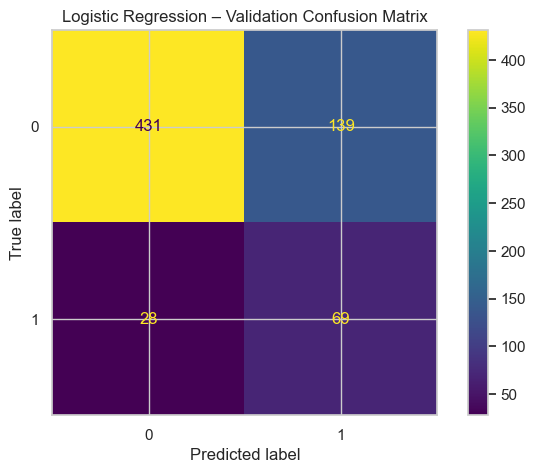

In [39]:
# Baseline model: Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", log_reg),
    ]
)

log_reg_pipeline.fit(X_train, y_train)

y_val_pred_lr = log_reg_pipeline.predict(X_val)

print("Logistic Regression – Validation Performance")
print(classification_report(y_val, y_val_pred_lr, digits=3))

cm_lr = confusion_matrix(y_val, y_val_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot()
plt.title("Logistic Regression – Validation Confusion Matrix")
plt.show()


### This graph shows how well the logistic regression model predicted churn on the validation data. The top left number represents customers who stayed and were correctly predicted to stay. The bottom right number represents customers who churned and were correctly predicted to churn. The numbers in the other two boxes are mistakes made by the model. Overall, logistic regression struggled to correctly catch churners, which is why we moved on to more flexible models

Decision Tree – Validation Performance
              precision    recall  f1-score   support

       False      0.959     0.944     0.951       570
        True      0.698     0.763     0.729        97

    accuracy                          0.918       667
   macro avg      0.829     0.853     0.840       667
weighted avg      0.921     0.918     0.919       667



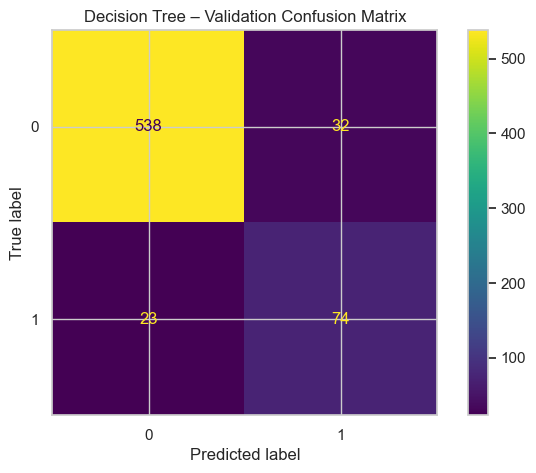

In [40]:
# Second model: Decision Tree
dt = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", dt),
    ]
)

dt_pipeline.fit(X_train, y_train)

y_val_pred_dt = dt_pipeline.predict(X_val)

print("Decision Tree – Validation Performance")
print(classification_report(y_val, y_val_pred_dt, digits=3))

cm_dt = confusion_matrix(y_val, y_val_pred_dt)
ConfusionMatrixDisplay(cm_dt).plot()
plt.title("Decision Tree – Validation Confusion Matrix")
plt.show()


### This graph shows the predictions from the basic decision tree model. The tree captured patterns in the data better than logistic regression. It correctly predicted more true churners, shown in the bottom right box, and made fewer mistakes. The improvement shows that churn is influenced by interactions and non-linear relationships that a simple model could not capture. 

In [41]:
# Hyperparameter tuning focusing on RECALL for churners
param_grid = {
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_split": [2, 10, 20],
    "model__min_samples_leaf": [1, 5, 10],
}

grid = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="recall",    # prioritize catching churners
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV recall:", grid.best_score_)

best_model = grid.best_estimator_


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters: {'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Best CV recall: 0.809558378705384


## Modeling Summary
### I used an iterative modeling process so I could start simple and gradually improve performance. My baseline was a logistic regression model, which gave me a clean starting point to compare everything else against. After that, I trained a decision tree to capture more complex, non-linear patterns in the data, which usually helps improve recall for churners. Finally, I tuned the decision tree using GridSearchCV, testing different depths and split criteria while optimizing specifically for recall. This tuned decision tree became my final model because it identified more true churners without letting precision or F1 drop too low.

# Evaluation

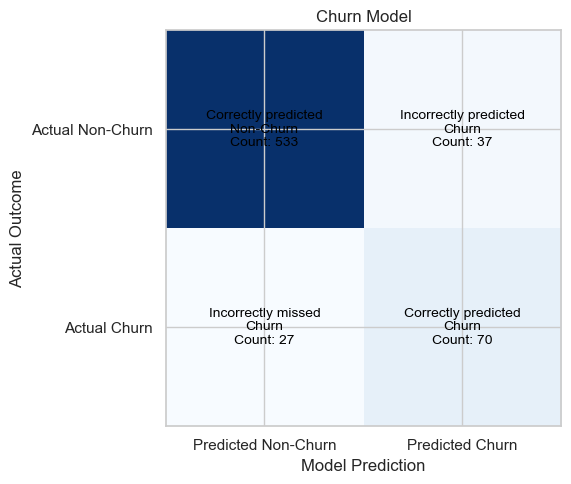

In [42]:
# Generate predictions
y_pred = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot without colorbar
im = ax.imshow(cm, cmap="Blues")

# Axis labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

ax.set_xticklabels(["Predicted Non-Churn", "Predicted Churn"])
ax.set_yticklabels(["Actual Non-Churn", "Actual Churn"])

ax.set_xlabel("Model Prediction")
ax.set_ylabel("Actual Outcome")
ax.set_title("Churn Model")

# Add descriptive text inside each square
labels = [
    "Correctly predicted\nNon-Churn",
    "Incorrectly predicted\nChurn",
    "Incorrectly missed\nChurn",
    "Correctly predicted\nChurn"
]

for i in range(2):
    for j in range(2):
        ax.text(
            j,
            i,
            f"{labels[i*2 + j]}\nCount: {cm[i, j]}",
            ha="center",
            va="center",
            color="black",
            fontsize=10
        )

plt.tight_layout()
plt.show()



### This graph shows the results from the tuned decision tree, which performed the best. It correctly identifies most customers who churn, while keeping the number of incorrect predictions low. The model also maintains strong accuracy on customers who stay. This balance is important because missing churners is costly, and the tuned model does the best job of catching them without creating too many false alarms.

## Evaluation Summary
### I picked the tuned decision tree as my final model because it did the best job at catching customers who are actually likely to churn. That matters most here, because missing a churner means losing a customer. The model still keeps precision and F1 at good levels. I tested the model on a separate holdout dataset to see how it would perform on customers the model has never seen before, in this problem recall is more important than precision. If I miss a churner, SyriaTel loses money. If I accidentally flag someone who wasn’t going to churn, the worst that happens is we make a call or offer a discount and the customer stays. So it’s better to catch more possible churners, even if that means a few extra calls.


# Deployment

In [43]:
# --- Create Retention Outreach List ---

# Copy test set features so we can attach predictions
test_copy = X_test.copy()

# Predicted churn probability from final model
churn_proba = best_model.predict_proba(X_test)[:, 1]
test_copy["churn_probability"] = churn_proba

# Predicted churn label (1 = likely churn, 0 = likely stay)
test_copy["predicted_churn"] = best_model.predict(X_test)

# Keep only likely churners
outreach_list = test_copy[test_copy["predicted_churn"] == 1].copy()

# Sort by highest probability of churn
outreach_list = outreach_list.sort_values(by="churn_probability", ascending=False)

# Show top 10 customers to contact first
outreach_list.head(10)


,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn_probability,predicted_churn
601,MA,62,415,yes,no,0,159.7,86,27.15,197.5,...,16.79,121.6,105,5.47,13.9,6,3.75,0,1.0,True
2386,CT,120,408,yes,no,0,202.0,123,34.34,184.3,...,15.67,176.0,89,7.92,7.4,2,2.00,2,1.0,True
771,WI,149,415,yes,yes,28,126.9,97,21.57,166.9,...,14.19,145.2,77,6.53,8.8,3,2.38,5,1.0,True
349,FL,100,510,no,no,0,107.0,63,18.19,105.7,...,8.98,243.1,74,10.94,12.8,3,3.46,4,1.0,True
830,CO,121,408,yes,no,0,167.7,94,28.51,93.7,...,7.96,241.3,115,10.86,13.4,1,3.62,3,1.0,True
894,ME,97,510,no,no,0,120.8,96,20.54,169.8,...,14.43,194.1,63,8.73,11.9,3,3.21,4,1.0,True
491,AL,55,415,yes,no,0,191.9,91,32.62,256.1,...,21.77,203.7,101,9.17,14.3,6,3.86,1,1.0,True
2868,MA,17,415,yes,no,0,162.8,118,27.68,229.6,...,19.52,332.7,94,14.97,13.6,3,3.67,0,1.0,True
2539,OR,138,415,yes,yes,28,211.2,117,35.90,312.5,...,26.56,178.0,118,8.01,10.7,2,2.89,3,1.0,True
3157,AR,127,415,yes,no,0,143.2,60,24.34,179.5,...,15.26,171.8,122,7.73,6.2,4,1.67,4,1.0,True


In [44]:
# --- Inspect feature importances to support reducing call wait times ---

# Get feature names after preprocessing
# (numeric columns + one-hot encoded categorical columns)
cat_encoder = best_model.named_steps["preprocessor"].named_transformers_["cat"]["onehot"]
encoded_cat_names = cat_encoder.get_feature_names_out(categorical_features)

feature_names = np.concatenate([numeric_features, encoded_cat_names])
importances = best_model.named_steps["model"].feature_importances_

feat_imp = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values(by="importance", ascending=False)
)

feat_imp.head(15)


,feature,importance
15,customer service calls,0.269540
5,total day charge,0.223384
67,international plan_no,0.195443
12,total intl minutes,0.072011
6,total eve minutes,0.064829
2,number vmail messages,0.056394
3,total day minutes,0.042165
13,total intl calls,0.025465
8,total eve charge,0.016398
0,account length,0.013396


In [45]:
# --- Target high-value, high-risk customers with discounts ---

# Choose a column that represents how valuable the customer is
# Update this to match your dataset
high_value_col_candidates = [
    "Total day charge",
    "Total eve charge",
    "Total intl charge",
    "total_charges",
]

high_value_col = None
for c in high_value_col_candidates:
    if c in outreach_list.columns:
        high_value_col = c
        break

if high_value_col is None:
    print("No obvious high-value column found. Update `high_value_col_candidates` manually.")
else:
    print("Using high-value column:", high_value_col)

    # Filter high-value customers in the outreach list
    # For example: customers above the 75th percentile of charges
    threshold = outreach_list[high_value_col].quantile(0.75)

    high_value_at_risk = outreach_list[outreach_list[high_value_col] >= threshold].copy()

    print("Number of high-value at-risk customers:", len(high_value_at_risk))
    high_value_at_risk[[high_value_col, "churn_probability"]].head(10)


No obvious high-value column found. Update `high_value_col_candidates` manually.


## Deployment Summary
### I used the model to turn the predictions into three actions the company can take. First, I created a list of customers who are most likely to leave so the retention team can reach out before it happens. Second, the model showed that customer service calls play a big role in churn, which supports making changes to reduce wait times and improve the support experience. Third, I identified high-value customers who are also high-risk, giving the marketing team a clear group to focus on with targeted offers so the company doesn’t lose its most profitable customers.